In [1]:
import sys
sys.path.append('../')
from xd import *
import numpy as np
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFactor = HF(100, 10)

from systematics_module.corr import angular_correlation_poisson, angular_correlation

In [2]:
def BOSSveto(cat, option='SGC'):
    
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        vetomaskNGC = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

In [3]:
#root = '/n/des/lee.5922/data/cmass_cat/dr12_multidark_patchy_mocks/'
basedir = '../data_txt/cmass/'

In [25]:

#cmass_ngc = esutil.io.read(path+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc = esutil.io.read(path+'cmass-dr12v4-S-Reid-full.dat.fits')
#cmass_ngc = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.7)]

cmasspath = '/n/des/lee.5922/data/cmass_cat/'
#cmass_ngc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_North.fits.gz')
#rand_ngc = esutil.io.read(cmasspath+'random0_DR12v5_CMASS_North.fits.gz')
cmass_sgc = esutil.io.read(cmasspath+'galaxy_DR12v5_CMASS_South.fits.gz')
rand_sgc = esutil.io.read([cmasspath+'random0_DR12v5_CMASS_South.fits.gz'
                          # ,cmasspath+'random1_DR12v5_CMASS_South.fits.gz'
                          ], combine=True)
#cmass_ngc = esutil.io.read(cmasspath+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc_reid = esutil.io.read(cmasspath+'cmass-dr12v4-S-Reid-full.dat.fits')

cmass_sgc_zcut = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
rand_sgc_zcut = rand_sgc[(rand_sgc['Z'] > 0.43) & (rand_sgc['Z'] < 0.7)]

In [5]:
cmass_sgc.size, rand_sgc.size

(230831, 11636252)

In [61]:
#cmass_weight = cmass_ngc['WEIGHT_SYSTOT']*(cmass_ngc['WEIGHT_CP']+cmass_ngc['WEIGHT_NOZ']-1.)
#cmass_ngc = appendColumn(cat = cmass_ngc, name='WEIGHT', value=cmass_weight)
#rand_ngc = appendColumn(cat = rand_ngc, name='WEIGHT_RAND', value=np.ones(rand_ngc['WEIGHT_FKP'].size))

In [26]:
cmass_weight = cmass_sgc['WEIGHT_SYSTOT']*(cmass_sgc['WEIGHT_CP']+cmass_sgc['WEIGHT_NOZ']-1.)
cmass_sgc = appendColumn(cat = cmass_sgc, name='WEIGHT', value=cmass_weight)
rand_sgc = appendColumn(cat = rand_sgc, name='WEIGHT_RAND', value=np.ones(rand_sgc['WEIGHT_FKP'].size))

cmass_zcut_weight = cmass_sgc_zcut['WEIGHT_FKP'] * cmass_sgc_zcut['WEIGHT_SYSTOT'] * (cmass_sgc_zcut['WEIGHT_CP']+cmass_sgc_zcut['WEIGHT_NOZ']-1.)
cmass_sgc_zcut = appendColumn(cat = cmass_sgc_zcut, name='WEIGHT', value=cmass_zcut_weight)
rand_sgc_zcut = appendColumn(cat = rand_sgc_zcut, name='WEIGHT_RAND', value=rand_sgc_zcut['WEIGHT_FKP'])

0

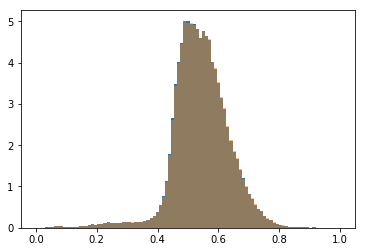

In [66]:
fig, ax = plt.subplots()
zbin = np.linspace(0,1,100)
ax.hist(cmass_sgc['Z'], bins=zbin, normed=1 )
ax.hist(rand_sgc['Z'], bins=zbin, normed=1,alpha=0.5 )
0

In [42]:
rand_sgc_veto = BOSSveto(rand_sgc, option='SGC')
cmass_sgc_veto = BOSSveto(cmass_sgc, option='SGC')

In [62]:
angular_correlation_poisson(data = cmass_ngc, rand = rand_ngc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_North', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_North.txt


In [319]:
def NNpairCount(data, rand, weight_data = None, weight_rand = None, 
    nbins = 20, min_sep = 2.5/60., max_sep = 250/60., dir = './', suffix=''):
    # cmass and balrog : all systematic correction except obscuration should be applied before passing here
    
    import treecorr
    
    if weight_data : weight_data = data['WEIGHT']
    if weight_rand : weight_rand = rand['WEIGHT_RAND']

    cat = treecorr.Catalog(ra=data['RA'], dec=data['DEC'], w = weight_data, ra_units='deg', dec_units='deg')
    cat_rand = treecorr.Catalog(ra=rand['RA'], dec=rand['DEC'], is_rand=True, w = weight_rand, ra_units='deg', dec_units='deg')
    #nbins = 20
    #bin_size = 0.5
    #min_sep = 2.5/60.
    #max_sep = 250/60.
    sep_units = 'degree'

    dd = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units)
    dr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units)
    rr = treecorr.NNCorrelation(nbins = nbins, max_sep = max_sep, min_sep= min_sep, sep_units=sep_units)
    
    dd.process(cat)
    dr.process(cat,cat_rand)
    rr.process(cat_rand)
    
    dd.write(dir+'npairs'+suffix+'.txt', rr=rr, dr=dr)
    print 'file save to', dir+'npairs'+suffix+'.txt'
    #xi, varxi = dd.calculateXi(rr,dr)
    #errxi = np.sqrt(varxi)
    
    return dd, dr, rr

In [322]:
basedir

'../data_txt/mocks_hybrid/'

In [330]:
dd, dr, rr = NNpairCount(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_North_10bins', dir = '../data_txt/cmass/')

#xi, varxi = dd.calculateXi(dr, rr)
#dd.write()

file save to ../data_txt/cmass/npairs_DR12v5_CMASS_North_10bins.txt


In [340]:
rr.tot, np.sum(rand_sgc['WEIGHT_RAND'])**2 /2.

(67701180303752.0, 67701180303752.0)

In [338]:
dd.tot, np.sum(cmass_sgc['WEIGHT'])**2 /2., np.sum(dd.weight)

(31175440221.598083, 31175439059.05774, 560973190.6192915)

In [326]:
cat ../data_txt/cmass/npairs_DR12v5_CMASS_North_20bins.txt

#   R_nom       meanR       meanlogR        xi        sigma_xi        DD           RR           DR         npairs   
  5.2455e-02   5.4695e-02  -2.9143e+00   1.9167e-01   3.2291e-03   1.1430e+05   9.5905e+04   9.5909e+04   9.7828e+04
  8.3136e-02   8.6659e-02  -2.4542e+00   1.3220e-01   2.0435e-03   2.7137e+05   2.3947e+05   2.3960e+05   2.3347e+05
  1.3176e-01   1.3736e-01  -1.9935e+00   9.4881e-02   1.2952e-03   6.5303e+05   5.9613e+05   5.9630e+05   5.6157e+05
  2.0883e-01   2.1778e-01  -1.5326e+00   6.7481e-02   8.2163e-04   1.5821e+06   1.4813e+06   1.4817e+06   1.3607e+06
  3.3097e-01   3.4535e-01  -1.0716e+00   4.3780e-02   5.2021e-04   3.8591e+06   3.6953e+06   3.6963e+06   3.3232e+06
  5.2455e-01   5.4710e-01  -6.1149e-01   2.9499e-02   3.2976e-04   9.4488e+06   9.1959e+06   9.1868e+06   8.1496e+06
  8.3136e-01   8.6734e-01  -1.5068e-01   1.9893e-02   2.0966e-04   2.3101e+07   2.2750e+07   2.2699e+07   1.9925e+07
  1.3176e+00   1.3744e+00   3.0963e-01   5.9812e-03   1.3372e-04

In [272]:
meanr = dd.meanr * 60
dlnr = dd.bin_size
dA = 2 * np.pi * meanr**2 * dlnr

npairs = dd.npairs
shotnoise = dA * 1./npairs

In [174]:
xi2 = dd.weight/ (rr.weight * dd.tot*1./rr.tot) - 1. 

In [218]:
rrw = rr.weight * dd.tot/rr.tot
varxi2 = ( dd.weight/rrw )**2 * (1/dd.weight + 1./rrw)

In [229]:
drw = dr.weight * dd.tot/dr.tot
varxi3 = (dd.weight/rrw)**2 * (1/dd.weight + 1./rrw) + 2*( drw/rrw )**2 * (1./drw + 1./rrw)

In [243]:
varxi4 =  2./dd.tot /rrw

In [244]:
varxi4

array([6.68923414e-16, 2.67890684e-16, 1.07616016e-16, 4.33086920e-17,
       1.73608722e-17, 6.97623203e-18, 2.81989840e-18, 1.14717534e-18,
       4.70157151e-19, 1.95240368e-19])

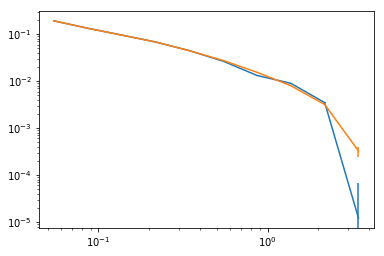

In [217]:
fig, ax = plt.subplots()
ax.errorbar(dd.meanr, xi, yerr = np.sqrt(varxi))
ax.errorbar(dd.meanr, xi2, yerr = np.sqrt(varxi2))
ax.set_xscale('log')
ax.set_yscale('log')

In [180]:
1./dd.weight * xi**2

array([3.21866131e-07, 6.58119542e-08, 1.40246428e-08, 2.94671220e-09,
       5.15877737e-10, 7.44822225e-11, 7.53113893e-12, 1.42746431e-12,
       8.85754325e-14, 4.43905465e-19])

In [181]:
varxi

array([1.04265015e-05, 4.17370369e-06, 1.67701535e-06, 6.74900249e-07,
       2.70539583e-07, 1.08852296e-07, 4.40546512e-08, 1.78639963e-08,
       7.32639198e-09, 3.04430662e-09])

In [161]:
xi2 = dd.weight * 1./ (rr.weight* dd.tot/rr.tot) - 1.
print xi2

[0.19176414 0.13320376 0.09544483 0.06802462 0.04434757 0.02750119
 0.01540444 0.00797985 0.00317107 0.00032558]


In [165]:
varnpairs = 2*1./ dd.npairs * xi**2
print varnpairs

[3.59236080e-04 1.46416393e-04 5.97512657e-05 2.43296683e-05
 9.84661187e-06 3.97678274e-06 1.61477022e-06 6.60677571e-07
 2.70826531e-07 1.12455517e-07]


In [153]:
dd.tot, dr.tot

(31175440221.598083, 2905590542035.3047)

In [304]:
sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/')
from su_utils import read_cov, imshowplot
cov_an_cmass_filename = '/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_mg_deltab_gauss/cov/cov_mcal4_cmass_sgc_20bins'
cov_an_cmass = read_cov( covfilename=cov_an_cmass_filename )[-20:, -20:]

cov_jk_cmass_1 = np.genfromtxt('../data_txt/mocks/acf_auto_DR12v5_CMASS_South_veto_jk100.cov')
fisher_jk = HF(100,10) * np.linalg.inv(cov_jk_cmass_1)
cov_jk_cmass = np.linalg.inv(fisher_jk)
print cov_jk_cmass.shape

(10, 10)


In [ ]:
2*1./

In [306]:
xi_i = []
for i in range(1,1001):
    try:
        meanr_mocks, xi, _ = np.loadtxt('../data_txt/mocks_bin20///acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_{:04}.txt'.format(i), unpack=True)
        #ax.errorbar(meanr, xi, yerr = xi_err, fmt = '-', color='r', alpha = 0.5)
        xi_i.append(xi)
    except (IOError, ValueError): pass
    
xi_i = np.array(xi_i)

xi = np.mean(xi_i, axis=0)
#xi_list_sigma = np.std(xi_i, axis=0)


Nsample, nthetabins = xi_i.shape
print Nsample

xi_cov = np.zeros((nthetabins, nthetabins))
for i in range(nthetabins):
    for j in range(nthetabins):
        xi_cov[i][j] = 1./ (Nsample-1.) * np.sum( (xi_i[:, i] - xi[i]) * (xi_i[:,j]-xi[j] ))

Hartlap_mock = 1.0 #HF(Nsample, nthetabins)
xi_cov_corrected = np.linalg.inv( Hartlap_mock * np.linalg.inv( xi_cov ) )


161


0

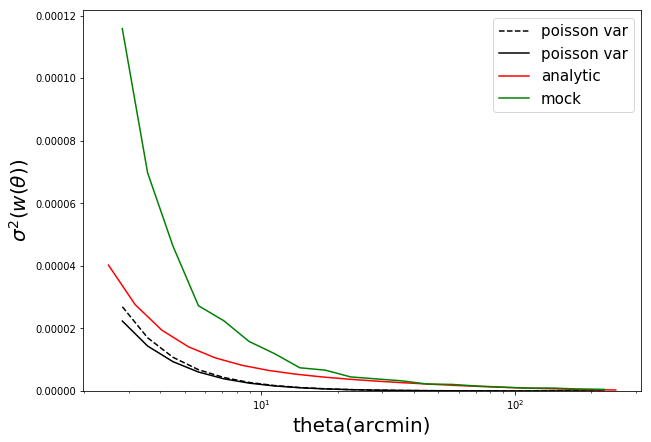

In [308]:
theta = np.logspace(np.log10(2.5), np.log10(250), 10)
theta2 = np.logspace(np.log10(2.5), np.log10(250), 20)

fig, ax = plt.subplots(figsize = (10,7))
#ax.plot( meanr*60, varxi, 'k--', label='poisson var')
ax.plot( dd.meanr*60, varxi, 'k--', label='poisson var')
#ax.plot( theta, varxi2, 'k--', label='poisson var')
ax.plot( dd.meanr*60, 1./ dd.weight, 'k-', label='poisson var')
#ax.plot( meanr*60, varxi3, 'r--', label='poisson var')
#ax.plot( theta, cov_jk_cmass.diagonal(), 'b-', label='jk ')
ax.plot( theta2, cov_an_cmass.diagonal(), 'r-', label='analytic')
ax.plot( meanr_mocks*60, xi_cov_corrected.diagonal(), 'g-', label='mock')

ax.set_ylabel(r'$\sigma^2 ( w(\theta) )$', fontsize = 20)
ax.set_xlabel('theta(arcmin)', fontsize=20)
ax.legend(fontsize=15)

ax.set_xscale('log')
#fig.savefig('../figure/cov_analytic_mocks.png')
ax.set_ylim(0,)
0

In [148]:
dnpairs = dd.npairs
rnpairs = rr.npairs

npairs = dd.npairs*1./ dd.tot



In [150]:
dd.tot

31175440221.598083

In [113]:
dA = 2*np.pi* dd.rnom**2 * dd.bin_size
num_density = dd.npairs * 1./dA

In [115]:
num_density

array([12287403.08951014, 11674073.77303318, 11178965.17087349,
       10783853.94123716, 10484772.93008359, 10236120.94715199,
        9963303.70815274,  9689948.05536294,  9381654.07873668,
        8976368.71820154])

In [103]:
shotnoise = 1./(dd.npairs**2 * dA)

In [104]:
shotnoise

array([3.44214645e-10, 3.81333261e-11, 4.15859233e-12, 4.46890951e-13,
       4.72749955e-14, 4.95996643e-15, 5.23531499e-16, 5.53486021e-17,
       5.90460328e-18, 6.44982881e-19])

In [94]:
dd.weight

array([1.14296075e+05, 2.71373727e+05, 6.53026795e+05, 1.58206236e+06,
       3.85914345e+06, 9.44884701e+06, 2.31005860e+07, 5.63688854e+07,
       1.36882950e+08, 3.28692020e+08])

In [95]:
dd.rnom

array([0.05245523, 0.08313593, 0.13176157, 0.20882801, 0.3309701 ,
       0.52455225, 0.8313593 , 1.31761569, 2.08828014, 3.30970098])

In [78]:
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR11v1_CMASS_South', dir = basedir)

angular_correlation_poisson(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR11v1_CMASS_South_zcut', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR11v1_CMASS_South.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR11v1_CMASS_South_zcut.txt


In [27]:
#os.system('rm ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South.txt')
#os.system('rm ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut.txt')

random_ind = np.random.choice( rand_sgc.size, size = rand_sgc.size/10)
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc[random_ind], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_ran10', dir = basedir)

random_ind = np.random.choice( rand_sgc.size, size = rand_sgc.size/5)
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc[random_ind], 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_ran5', dir = basedir)

angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South', dir = basedir)

angular_correlation_poisson(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_zcut', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran10.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran5.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut.txt


In [43]:
angular_correlation_poisson(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_DR12v5_CMASS_South_veto', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_veto.txt


In [27]:
angular_correlation_poisson(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass-dr12v4-S-Reid-full', dir = basedir)

angular_correlation_poisson(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight_data = True, weight_rand = True, 
                    suffix = '_cmass-dr12v4-S-Reid-full_zcut', dir = basedir)

saving data file to :  ../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full.txt
saving data file to :  ../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full_zcut.txt


In [80]:
angular_correlation(data = cmass_sgc_zcut, rand = rand_sgc_zcut, 
                    nbins=10, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_zcut_jk100', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
11 iterations  cluster sizes: [ 5 13 18 10  3  7 11 12  6 10  6 18  5  8  6 20 12  7  9  2 11  7 23  9
  5 11 14  8 11 11  6  9 11 12  8  9  5 13 12  6  5  9  8  3 12  8  9 12
 14  6 19 17 18 15  6  9  6  8  6 23 11  6  5  7  7 17  9 10  9  7 15  9
  5 12 14 13  6  6  0  8 16 14  5 21  5  7  9 11  8 11 12 12  8 20 11 17
  7  8 12  8]
X (208426, 2)  centers (100, 2)  tol=1e-05  maxiter=200
140 iterations  cluster sizes: [2104 2410 2355 1594 1948 1804 2589 1644 1790 2544 2077 2217 1608 2286
 2165 1945 2108 1688 2109 1984 2262 2169 3112 1896 1918 2300 1962 1945
 1629 2265 1960 2117 2432 2400 2112 2249 1903 2123 2363 2007 2062 1741
 2276 2408 2117 1689 2175 2394 2180 2025 2391 2370 2450 2060 2286 1662
 1514 1909 1676 2022 2063 1911 2241 2176 2055 1998 2338 2603 2237 2280
 1582 2041 2034 2546 2033 2283 2283 2093 1841 1395 2132 1767 2279 2084
 2022 2026 1479 2067 1772 1639 2021 2654 2229 2258 2232 23

In [84]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 50, 
                    suffix = '_DR12v5_CMASS_South_jk50', dir = basedir)

calculate angular correlation function
X (960, 2)  centers (50, 2)  tol=1e-05  maxiter=200
19 iterations  cluster sizes: [16 22 36 17 24 14 22 14  9 30 30 17 34 11  6 22 13 34 18 20 23 29 11 22
 21 17 23  9 19 37 22 24 18 15 10 14 17 14 12  9 13 18 15 26 19 17 15  9
 39 14]
X (230831, 2)  centers (50, 2)  tol=1e-05  maxiter=200
72 iterations  cluster sizes: [4480 4232 4478 5079 5167 3436 4285 3672 3953 5417 5985 5724 7109 3416
 4212 4571 4429 4514 5561 6891 4118 5312 4217 4614 5531 4384 4760 4833
 3615 5513 3434 5636 3094 5600 4027 4176 4237 3723 4047 4423 4454 4040
 3331 4753 4554 4004 4703 3752 6461 4874]
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/mocks//acf_auto_DR12v5_CMASS_South_jk50.txt


In [86]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 20, 
                    suffix = '_DR12v5_CMASS_South_jk20', dir = basedir)

calculate angular correlation function
X (960, 2)  centers (20, 2)  tol=1e-05  maxiter=200
32 iterations  cluster sizes: [50 50 41 32 33 50 36 59 47 58 63 45 31 60 64 31 48 71 48 43]
X (230831, 2)  centers (20, 2)  tol=1e-05  maxiter=200
52 iterations  cluster sizes: [11002 11318 11954 11015 11867 14400  9708 10743 12963 10431 10870 11948
 11498 11660 12194 10907 11065 13348 10767 11173]
. . . . . . . . . . . . . . . . . . . . . saving data file to :  ../data_txt/mocks//acf_auto_DR12v5_CMASS_South_jk20.txt


In [72]:
angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 100, 
                    suffix = '_DR12v5_CMASS_South_jk100', dir = basedir)

angular_correlation(data = cmass_sgc, rand = rand_sgc, 
                    nbins=10, weight = [True, True], njack = 150, 
                    suffix = '_DR12v5_CMASS_South_jk150', dir = basedir)

calculate angular correlation function
X (1000, 2)  centers (100, 2)  tol=1e-05  maxiter=200
22 iterations  cluster sizes: [ 6 12 10 12  7 12  9 13  5  8 10 11  9 11 17  9  9 22  6  8 10  5 10 12
  8 10  6 14  8  9 12 11 18  1 11 12  5  9  8 10  2  7 22  5  9  6  8 16
  8 15 19 11 11 10  5  5  7 14 10 17  4 17 11 17  9 15 10  7 11 12 11  3
 10 10 13 12  1  6  8  5 15 11  9  9  9 11  6  7 12  8  4 14 12 13 11 10
 13 15  8  9]
X (230831, 2)  centers (100, 2)  tol=1e-05  maxiter=200
132 iterations  cluster sizes: [2471 2069 2109 2188 2393 2544 2603 2398 2646 2470 2423 2409 2546 2188
 2521 1999 1841 2127 2188 2268 2864 1805 1634 2656 2422 2122 1685 2409
 1785 2038 2322 2295 2676 2126 2599 2678 1911 2591 2270 2258 2358 2227
 2416 2380 2488 1824 2278 2751 2059 2012 2330 1942 2322 2455 1705 2073
 1717 2413 3126 2164 1905 2680 2195 2544 2810 1953 3002 2778 1897 2409
 2799 2297 2051 2310 2345 2585 2064 2121 2092 2335 2547 2490 2385 2578
 2175 1920 1771 2877 2237 2687 2759 2436 2462 2645 2185 21

In [100]:
rand_sgc_veto = BOSSveto(rand_sgc, option='SGC')
randind = np.random.choice( rand_sgc_veto.size, size = rand_sgc_veto.size/10)

cmass_sgc_veto = BOSSveto(cmass_sgc, option='SGC')

angular_correlation(data = cmass_sgc_veto, rand = rand_sgc_veto, 
                    nbins=10, weight = [True, True], njack = 200, 
                    suffix = '_DR12v5_CMASS_South_veto_jk200', dir = basedir)

calculate angular correlation function
X (2000, 2)  centers (200, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [ 4  8  3  9 13  5 12 12  6  9 11  7  2 14 15 11 10 18 10 13  6  4 17  8
 10 17 12 12  4  4  7 10 16  8 12 10  6  8  6 10  6  9  7 10  9 27  5 12
  6  5 13  6  4  4 15 11  9 21  9  8  9 21 11  7  8 11 13 15  6  7  7 13
 12 15 11  8  4  5 15  8 12  7  8  8 15 10 11 21  9  9  6  4  7 18 11  2
 12  6 14  4  8  7  4 12  9  3 13  2 12  4 11 12 19 10 22 10  6  9 12 13
 12  5  7  5  9 19  0 11 12  4 10 21 10  8  8  6 18  3 12 13 12  7  5  7
 16 14  7 10 17 10  6 11 10  9 10 12 13 10 17  8  9 11 16  7 19  9 16  6
  9 10 14 11  4  4  7  7  8 11  3  8 17  2 17 20 10  4  6  8 11 21 13 22
 13 14  6  1 14  2 15 18]
X (217452, 2)  centers (200, 2)  tol=1e-05  maxiter=200
102 iterations  cluster sizes: [1083 1064  881  986 1007 1054 1334 1164  918 1307 1136 1038 1244  863
 1160 1199  885 1139 1138 1125 1021 1311  952 1020 1038 1327 1185  975
 1075  952  844 1084 1016 1047 1021 11

In [68]:
#path = '/n/des/lee.5922/data/cmass_cat/patchy_mock/'
#cmass_mock_rand_file_S = np.loadtxt(path+'Random-DR12CMASS-S-V6C-x10.dat')

In [73]:
#cmass_mock_file = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-S-V6C-Portsmouth-mass_0001.dat')
cmass_mock_rand_file = np.loadtxt('/n/des/lee.5922/data/cmass_cat/qpm_mocks/mock_random_DR12_CMASS_S_50x1.rdzw')

In [74]:
cmass_mock_rand_file.shape

(12161647, 4)

In [75]:

#cmass_mock_rand_file = np.loadtxt(path+'Random-DR12CMASS-N-V6C-x10.dat')
random_mock = np.zeros( (cmass_mock_rand_file.shape[0],), 
    dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_FKP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT_RAND', 'float')])
random_mock['RA'] = cmass_mock_rand_file[:,0]
random_mock['DEC'] = cmass_mock_rand_file[:,1]
random_mock['Z'] = cmass_mock_rand_file[:,2]
random_mock['WEIGHT_FKP'] = cmass_mock_rand_file[:,3]
#random_mock['WEIGHT_VETO'] = cmass_mock_rand_file[:,4]
random_mock['WEIGHT_RAND'] = cmass_mock_rand_file[:,3] # * random_mock['WEIGHT_VETO']

random_mock = BOSSveto(random_mock, option='SGC')

#random_mock = random_mock[(random_mock['Z'] > 0.43) & (random_mock['Z'] < 0.7)]

#cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
#random_mock = random_mock[ random_mock['VETO_FLAG'] == 1]

figsave : .//spatialtest_.png


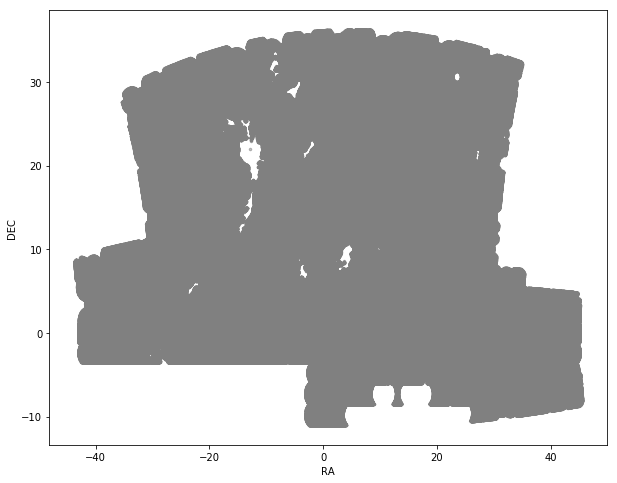

In [61]:
spatialcheck([random_mock])

In [ ]:
basedir =  '../data_txt/mocks_hybrid/'
os.system('mkdir '+basedir)

for i in range(1, 1001):
    try : 
        path = '/n/des/lee.5922/data/cmass_cat/qpm_mocks/'
        name = 'mock_galaxy_DR12_CMASS_S_QPM_{:04}'.format(i)
        #print path+name
        cmass_mock_file = np.loadtxt(path+name+'.rdzw')

        #cmass_mock_file = np.loadtxt(path+'patchy_mock/Patchy-Mocks-DR12CMASS-N-V6C-Portsmouth-mass_0001.dat')
        cmass_mock = np.zeros( (cmass_mock_file.shape[0],), 
            dtype = [('RA', 'float'), ('DEC', 'float'), ('Z', 'float'),('WEIGHT_FKP', 'float'), ('WEIGHT_VETO', 'int'), ('WEIGHT', 'float')])
        cmass_mock['RA'] = cmass_mock_file[:,0]
        cmass_mock['DEC'] = cmass_mock_file[:,1]
        cmass_mock['Z'] = cmass_mock_file[:,2]
        cmass_mock['WEIGHT_FKP'] = cmass_mock_file[:,3]
        cmass_mock['WEIGHT_VETO'] = cmass_mock_file[:,4]
        #cmass_mock['VETO_FLAG'] = cmass_mock_file[:,6]
        cmass_mock['WEIGHT'] = cmass_mock_file[:,4] *cmass_mock_file[:,3]
        #cmass_mock = cmass_mock[ cmass_mock['VETO_FLAG'] == 1]
        cmass_mock = BOSSveto(cmass_mock, option='SGC')
        #angular_correlation_poisson(data = cmass_mock, rand = random_mock, 
        #                    nbins=10, weight_data = True, 
        #                    suffix = '_'+name, dir = basedir)

        angular_correlation(data = cmass_mock, rand = random_mock, 
                    nbins=10, weight = [True, True], njack = 10, 
                    suffix = '_'+name+'_jk10', dir = basedir, jkgenerate = True)
        
    except (IOError, ValueError): 
        print 'no files'
        pass

calculate angular correlation function
exiting jkregion file found : ../data_txt/mocks_hybrid/./jkregion.txt
generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (914, 2)  centers (10, 2)  tol=1e-05  maxiter=200
18 iterations  cluster sizes: [ 84 119  79  89 100  80  63 101 109  90]
X (209229, 2)  centers (10, 2)  tol=1e-05  maxiter=200
72 iterations  cluster sizes: [22692 20224 21518 19325 23041 21310 21613 19757 17884 21865]
. . . . . . . . . . . saving data file to :  ../data_txt/mocks_hybrid//acf_auto_mock_galaxy_DR12_CMASS_S_QPM_0001_jk10.txt
calculate angular correlation function
exiting jkregion file found : ../data_txt/mocks_hybrid/./jkregion.txt
generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (915, 2)  centers (10, 2)  tol=1e-05  maxiter=200
28 iterations  cluster sizes: [ 88  70  99  94 107  97  81  97  99  83]
X (209723, 2)  centers (10, 2)  tol=1e-05  maxiter=200
39 iterations  cluster sizes: [20677 19282 22633 24673 23590 18504 20268 21351 18

19 iterations  cluster sizes: [19937 23169 22840 21700 20233 17610 22515 23630 21417 19230]
. . . . . . . . . . . saving data file to :  ../data_txt/mocks_hybrid//acf_auto_mock_galaxy_DR12_CMASS_S_QPM_0015_jk10.txt
calculate angular correlation function
exiting jkregion file found : ../data_txt/mocks_hybrid/./jkregion.txt
generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (914, 2)  centers (10, 2)  tol=1e-05  maxiter=200
54 iterations  cluster sizes: [ 94  68  87  84  73  67  94 100 148  99]
X (209094, 2)  centers (10, 2)  tol=1e-05  maxiter=200
24 iterations  cluster sizes: [23555 18658 20580 18721 16669 17125 21545 27153 23122 21966]
. . . . . . . . . . . saving data file to :  ../data_txt/mocks_hybrid//acf_auto_mock_galaxy_DR12_CMASS_S_QPM_0016_jk10.txt
calculate angular correlation function
exiting jkregion file found : ../data_txt/mocks_hybrid/./jkregion.txt
generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (913, 2)  centers (10, 2)  tol=1e-05  maxit

generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (914, 2)  centers (10, 2)  tol=1e-05  maxiter=200
16 iterations  cluster sizes: [ 76  86  93  99  94 109 105  89  86  77]
X (209134, 2)  centers (10, 2)  tol=1e-05  maxiter=200
21 iterations  cluster sizes: [19829 19696 20216 21069 20195 23699 20585 23436 21754 18655]
. . . . . . . . . . . saving data file to :  ../data_txt/mocks_hybrid//acf_auto_mock_galaxy_DR12_CMASS_S_QPM_0031_jk10.txt
calculate angular correlation function
exiting jkregion file found : ../data_txt/mocks_hybrid/./jkregion.txt
generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (920, 2)  centers (10, 2)  tol=1e-05  maxiter=200
20 iterations  cluster sizes: [ 69  99  96 105  99  84  83  71 124  90]
X (211746, 2)  centers (10, 2)  tol=1e-05  maxiter=200
26 iterations  cluster sizes: [17762 18406 23048 18901 23337 20856 21120 22392 24151 21773]
. . . . . . . . . . . saving data file to :  ../data_txt/mocks_hybrid//acf_auto_mock_galaxy_DR12_C

. . . . . . . . . . . saving data file to :  ../data_txt/mocks_hybrid//acf_auto_mock_galaxy_DR12_CMASS_S_QPM_0045_jk10.txt
calculate angular correlation function
exiting jkregion file found : ../data_txt/mocks_hybrid/./jkregion.txt
generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (916, 2)  centers (10, 2)  tol=1e-05  maxiter=200
37 iterations  cluster sizes: [133  74  94 116  59  78  84  85 111  82]
X (209767, 2)  centers (10, 2)  tol=1e-05  maxiter=200
32 iterations  cluster sizes: [23527 19509 21436 20417 18664 20423 19148 23646 21055 21942]
. . . . . . . . . . . saving data file to :  ../data_txt/mocks_hybrid//acf_auto_mock_galaxy_DR12_CMASS_S_QPM_0046_jk10.txt
calculate angular correlation function
exiting jkregion file found : ../data_txt/mocks_hybrid/./jkregion.txt
generate new jkregion : ../data_txt/mocks_hybrid/./jkregion.txt
X (919, 2)  centers (10, 2)  tol=1e-05  maxiter=200
26 iterations  cluster sizes: [ 91  92  83  91  99  90 103 106  60 104]
X (211467, 2)

In [58]:
xi_list = []
for i in range(1,1001):
    try:
        meanr, xi, _ = np.loadtxt('../data_txt/mocks/acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_{:04}.txt'.format(i), unpack=True)
        #ax.errorbar(meanr, xi, yerr = xi_err, fmt = '-', color='r', alpha = 0.5)
        xi_list.append(xi)
    except (IOError, ValueError): pass
    
xi_list = np.array(xi_list)
xi_list_mean = np.mean(xi_list, axis=0)
xi_list_sigma = np.std(xi_list, axis=0)

In [ ]:
#RA, DEC, Z, MSTAR, NBAR, BIAS, VETO FLAG, FIBER COLLISION

In [ ]:
meanr4, xi4, xi_err4 = np.loadtxt('../data_txt/cmass/acf_auto_poisson_DR12v5_CMASS_South.', unpack=True)

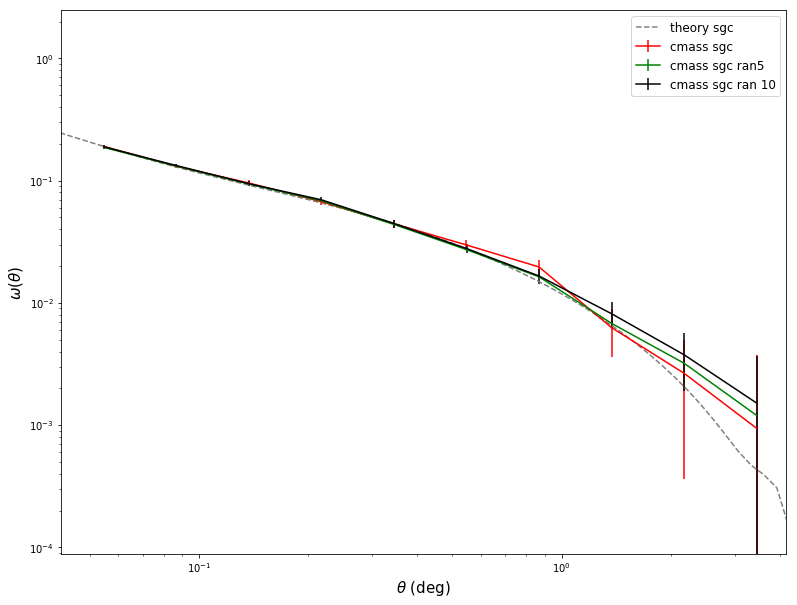

In [71]:
import scipy

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_dmass_weight0_pcut01_nbins10_jk100.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran10.txt', unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_ran5.txt', unpack=True)
#meanr4, xi4, xi_err4 = np.loadtxt('../data_txt/cmass/acf_auto_poisson_DR12v5_CMASS_South.txt', unpack=True)
meanr4, xi4, xi_err4 = np.loadtxt('../data_txt/mocks/acf_auto_DR12v5_CMASS_South_veto_jk200.txt', unpack=True)
meanr5, xi5, xi_err5 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut.txt', unpack=True)
#meanr6, xi6, xi_err6 = np.loadtxt('../data_txt/mocks/acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0001.txt', unpack=True)

#../data_txt//acf_auto_poisson_cmass_full_sys_cp_nz_weight_nbins10_jk200.txt
#meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_no_weight.txt', unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_DR12v5_CMASS_South_zcut_no_weight.txt', unpack=True)
#meanr2, xi2, xi_err2 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full.txt', unpack=True)
#meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/cmass//acf_auto_poisson_cmass-dr12v4-S-Reid-full_zcut.txt', unpack=True)

meanr, xi, xi_err = np.loadtxt('../data_txt/mocks/acf_auto_DR12v5_CMASS_South_jk50.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))

    
#ax.errorbar(meanr, xi, yerr = xi_err, fmt = 'o-', color='r', label='cmass mock')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='b', label='cmass sgc ran10')
ax.errorbar(meanr4, xi4, yerr = xi_err4, fmt = '-', color='r', label='cmass sgc')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='cmass sgc ran5')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k', color='r', label='cmass sgc ran 10')

#ax.errorbar(meanr5, xi5, yerr = xi_err5, fmt = '--', color='skyblue', label='cmass sgc zcut + all weights')
#ax.errorbar(meanr6, xi6, yerr = xi_err6, fmt = '--', color='r', label='jk')

#ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)



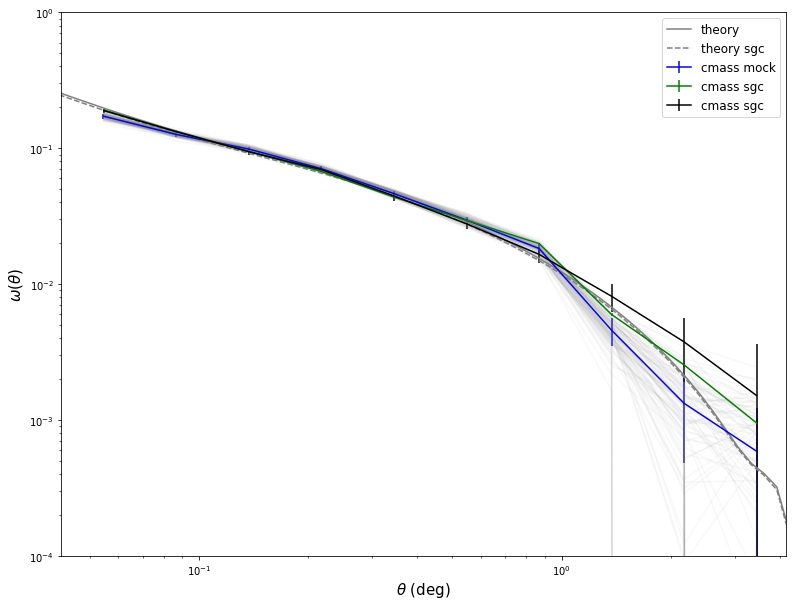

In [69]:
import scipy

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_dmass_weight0_pcut01_nbins10_jk100.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(rootdir+'/act//acf_auto_dmass_veto_pcut01_nbins10_jk100.txt', unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/mocks//acf_auto_poisson_DR12v5_CMASS_South.txt', unpack=True)

#
meanr, xi, xi_err = np.loadtxt('../data_txt/mocks//acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_0001.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))


for i in range(1,101):
    try:
        meanr, xi, xi_err = np.loadtxt('../data_txt/mocks/acf_auto_poisson_mock_galaxy_DR12_CMASS_S_QPM_{:04}.txt'.format(i), unpack=True)
        ax.plot(meanr, xi, color='grey', alpha = 0.05)
    
    except (IOError, ValueError): pass
    
ax.errorbar(meanr, xi_list_mean, yerr = xi_list_sigma, fmt = '-', color='b', label='cmass mock')
#ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='r', label='dmass vetoed')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='cmass sgc')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k-', color='r', label='cmass sgc')

ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)


In [22]:
xi_list_sigma

array([0.00580633, 0.00446376, 0.00351645, 0.00276759, 0.00223925,
       0.00199084, 0.00193024, 0.00166533, 0.00153357, 0.00128082])

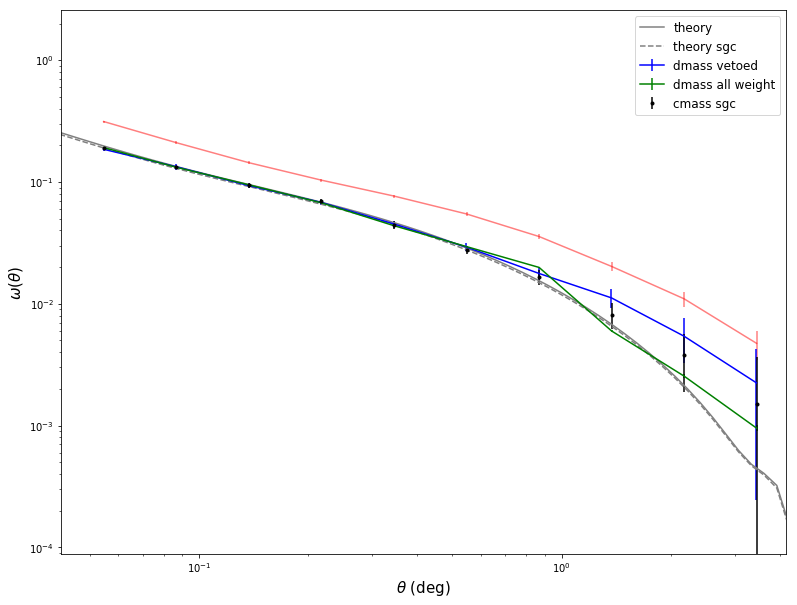

In [23]:
import scipy

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'

theta_th, theory = np.loadtxt('../data_txt/acf_cmass_ngc_theory.txt', unpack=True)
theta_th, theory_sgc = np.loadtxt('../data_txt/acf_cmass_sgc_theory.txt', unpack=True)

#_, theory_bias = np.loadtxt('../data_txt/acf_cmass_sgc_theory_bias.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_gold_st82_nbins10_jk100.txt', unpack=True)
#meanr, xi, xi_err = np.loadtxt(rootdir+'/act//acf_auto_dmass_weight0_pcut01_nbins10_jk100.txt', unpack=True)
meanr2, xi2, xi_err2 = np.loadtxt(rootdir+'/act//acf_auto_dmass_veto_pcut01_nbins10_jk100.txt', unpack=True)
meanr3, xi3, xi_err3 = np.loadtxt('../data_txt/mocks//acf_auto_poisson_DR12v5_CMASS_South.txt', unpack=True)

#
meanr, xi, xi_err = np.loadtxt('../data_txt/mocks//acf_auto_poisson_Patchy-Mocks-DR12CMASS-S-V6C-Portsmouth-mass_0001.txt', unpack=True)

theory_interp = scipy.interpolate.interp1d(theta_th, theory)
theory_interp = theory_interp(meanr)
theory_sgc_interp = scipy.interpolate.interp1d(theta_th, theory_sgc)
theory_sgc_interp = theory_sgc_interp(meanr)

nzs_ratio = theory_sgc_interp/theory_interp


meanr_sgc, xi_sgc, xi_err_sgc = np.loadtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.txt',unpack=True)
cov_cmass_s = np.genfromtxt('../data_txt//acf_auto_cmass_sgc_sys_cp_nz_weight_nbins10_jk100.cov')




fig, ax = plt.subplots(figsize = (13, 10))

ax.errorbar(meanr, xi_list_mean, yerr = xi_list_sigma, fmt = '-', color='r', alpha = 0.5)
ax.errorbar(meanr2, xi2, yerr = xi_err2, fmt = '-', color='b', label='dmass vetoed')
ax.errorbar(meanr3, xi3, yerr = xi_err3, fmt = '-', color='g', label='dmass all weight')
ax.errorbar(meanr_sgc, xi_sgc, yerr = xi_err_sgc, fmt = 'k.', color='r', label='cmass sgc')

ax.plot(theta_th, theory, '-', color='grey', label='theory')
ax.plot(theta_th, theory_sgc, '--', color='grey', label='theory sgc')
#ax.plot(theta_th, theta_th*theory_bias, '--', color='green', label='theory bias')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc = 'best', fontsize = 12)
#ax.text(1.5, 0.07, r'$\chi^2 $ = {:0.3f}  (south)'.format(chisqr), fontsize = 12)
#ax.set_ylim(1e-4,1)
ax.set_xlim(2.5/60, 250./60)
ax.set_xlabel(r'$\theta$ (deg)', fontsize = 15)
ax.set_ylabel(r'$\omega(\theta)$', fontsize = 15)

